In [40]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2
import matplotlib.image as mpimg
%matplotlib inline
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from skimage import filters
from skimage import measure
from skimage.color import rgb2gray
from skimage.morphology import closing, square

In [4]:
shared = '/home/siddhant/SharedFolder/DATA/Data/clean_data/'
shared = ''

In [5]:
classes = ['Alzheimer', 'MCI' ]

data = {}
labels = {}
for class_ in classes:
    print 'working on ' + class_ + '...'
    dirs_ = os.listdir(shared + class_)
    data_ = []
    for dir_ in dirs_:
        files_path =os.path.join(shared + os.path.join(class_, dir_), '*.nii')
        for file_ in glob.glob(files_path):
            temp_file = nib.load(file_).get_data()
            if temp_file.shape[0] != 64 or temp_file.shape[1] != 64 or temp_file.shape[2] !=48:
                continue
            data_.append(temp_file)
    data[class_] = np.array(data_)

working on Alzheimer...
working on MCI...


In [6]:
temp_concat = np.concatenate((data['Alzheimer'][0], data['Alzheimer'][1]), axis=3)
for i in range(2, data['Alzheimer'].shape[0]):
    temp_concat = np.concatenate((temp_concat, data['Alzheimer'][i]), axis=3)
data['Alzheimer'] = temp_concat
print data['Alzheimer'].shape

(64, 64, 48, 980)


In [7]:
# temp_concat = np.concatenate((data['Alzheimer _ 70'][0], data['Alzheimer _ 70'][1]), axis=3)
# for i in range(2, data['Alzheimer _ 70'].shape[0]):
#     temp_concat = np.concatenate((temp_concat, data['Alzheimer _ 70'][i]), axis=3)
# data['Alzheimer _ 70'] = temp_concat
# print data['Alzheimer _ 70'].shape

In [8]:
temp_concat = np.concatenate((data['MCI'][0], data['MCI'][1]), axis=3)
for i in range(2, data['MCI'].shape[0]):
    temp_concat = np.concatenate((temp_concat, data['MCI'][i]), axis=3)
data['MCI'] = temp_concat
print data['MCI'].shape

(64, 64, 48, 1540)


In [9]:
# temp_concat = np.concatenate((data['MCI _ 70'][0], data['MCI _ 70'][1]), axis=3)
# for i in range(2, data['MCI _ 70'].shape[0]):
#     temp_concat = np.concatenate((temp_concat, data['MCI _ 70'][i]), axis=3)
# data['MCI _ 70'] = temp_concat
# print data['MCI _ 70'].shape

In [10]:
# temp_concat = np.concatenate((data['Normal'][0], data['Normal'][1]), axis=3)
# for i in range(2, data['Normal'].shape[0]):
#     temp_concat = np.concatenate((temp_concat, data['Normal'][i]), axis=3)
# data['Normal'] = temp_concat
# print data['Normal'].shape

In [11]:
# temp_concat = np.concatenate((data['Normal _ 70'][0], data['Normal _ 70'][1]), axis=3)
# for i in range(2, data['Normal _ 70'].shape[0]):
#     temp_concat = np.concatenate((temp_concat, data['Normal _ 70'][i]), axis=3)
# data['Normal _ 70'] = temp_concat
# print data['Normal _ 70'].shape

In [14]:
#np.save('Normal',data['Normal'])

In [15]:
np.save('Alzheimer',data['Alzheimer'])

In [16]:
np.save('MCI',data['MCI'])

## Checkpoint


In [17]:
# normal=np.load('/home/siddhant/SharedFolder/DATA/Normal.npy')

In [19]:
mci=np.load('MCI.npy')

In [20]:
alzheimer=np.load('Alzheimer.npy')

In [21]:
alzheimer.shape

(64, 64, 48, 980)

In [22]:
mci.shape

(64, 64, 48, 1540)

In [24]:
# normal.shape

In [25]:
alzheimer=alzheimer.reshape(64,64,-1)
# normal=normal.reshape(64,64,-1)
mci=mci.reshape(64,64,-1)

In [26]:
combined_data=[]
for i in range(alzheimer.shape[2]):
    combined_data.append((alzheimer[:,:,i],0))
for i in range(mci.shape[2]):
    combined_data.append((mci[:,:,i],1))
# for i in range(normal.shape[2]):
#     combined_data.append((normal[:,:,i],2))
    
del(alzheimer)
# del(normal)
del(mci)

In [27]:
np.array(combined_data).shape

(120960, 2)

In [28]:
# shuffling of combined_data
random.shuffle(combined_data)
print len(combined_data)

120960


In [29]:
# get input and output.
X = map(lambda x: x[0],combined_data)
y = map(lambda x:x[1], combined_data)
print len(y)

120960


## Neural Network

###  Prepare Data

In [30]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

In [31]:
np.array(y_val).shape

(24192,)

In [32]:
def find_boundary_reverse(count,size):
    retval=count.size-1
    if count[count.size-1]==size or count[count.size-1]==0:
        for i in range(np.array(count).size-2, 0, -1):
            if(count[i] != count[i+1]):
                retval=i
                break
    return retval

def find_boundary(count,size):
    retval=0
    if count[0]==size or count[0]==0:
        for i in range(0,np.array(count).size-2, 1):
            if(count[i] != count[i+1]):
                retval=i
                break
    return retval

#crops an image from both dark and light background
#works best on a single color background
def crop_image(array,target_size = 64):
    print('Processing image')

    #otsu thresholding
    img = Image.fromarray(array)
    img=img.convert('RGB')
    blurred = img.filter(ImageFilter.BLUR)
    
    img_array = np.array(img)
    ba = np.array(blurred)
    gray_image = cv2.cvtColor(ba, cv2.COLOR_BGR2GRAY)
    retval2, threshold2 = cv2.threshold(gray_image, 125, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #storing white pixel in  each row and column in two arrays
    #these arrays are later used to find boundaries for cropping image
    row_white_pixel_count=np.count_nonzero(threshold2,axis=1)
    col_white_pixel_count=np.count_nonzero(threshold2,axis=0)

    #find x,y,w,h for cropping image
    y=find_boundary(row_white_pixel_count,col_white_pixel_count.size)
    h=find_boundary_reverse(row_white_pixel_count,col_white_pixel_count.size)
    x=find_boundary(col_white_pixel_count,row_white_pixel_count.size)
    w=find_boundary_reverse(col_white_pixel_count,row_white_pixel_count.size)
    crop_array = img_array[y:h, x:w]

    #resize the image
    crop_img=Image.fromarray(crop_array)
    resized = crop_img.resize([target_size, target_size])
    
    return np.asarray(resized)

In [33]:
def i16_to_rgb(array):
    plt.imsave('test.png', np.uint8(array))
    img = Image.open('test.png')
    img.load() 
    return np.asarray(img)

In [34]:
short_x_val=x_val[:1000]
short_y_val=y_val[:1000]

In [35]:
short_x_train=x_train[:10000]
short_y_train=y_train[:10000]

In [36]:
x_val2=map(i16_to_rgb,short_x_val)

In [37]:
# x_val=map(crop_image,x_val2)

In [38]:
x_train2 = map(i16_to_rgb, x_train)

converted i16_to_rgb image
(64, 64, 4)


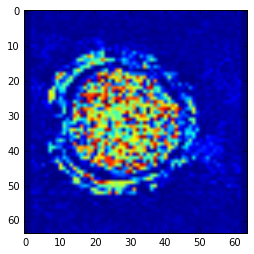

In [41]:
print 'converted i16_to_rgb image'
print x_train2[0].shape
plt.imshow(x_train2[0])
plt.show()

In [36]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D,Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import optimizers
optimizer=optimizers
# initialize the model
model = Sequential()

#first layer
model.add(Conv2D(96, 5, 5, border_mode="same",
    input_shape=(64, 64,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#second layer
model.add(Conv2D(144, 5, 5, border_mode="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#set of FC
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(3))
model.add(Activation("softmax"))

#get model summary
model.summary()

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 96)        7296      
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 144)       345744    
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 144)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 144)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
__________

/home/siddhant/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (5, 5), padding="same", input_shape=(64, 64, 3...)`
/home/siddhant/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(144, (5, 5), padding="same")`


In [37]:
def batch_generator(X, y, batch_size,samples_per_epoch):
    number_of_batches = (samples_per_epoch)/batch_size
    counter=0
    while 1:
        X_batch = X[counter*batch_size:(counter+1)*batch_size]
        y_batch = y[counter*batch_size:(counter+1)*batch_size]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter == (number_of_batches - 1)):
            break

In [38]:
# model.fit_generator(generator=batch_generator(x_train2, short_y_train, 512,9999),
#                     nb_epoch=25, samples_per_epoch=9999,
#                     validation_data=batch_generator(x_val2, short_y_val, 512,999), nb_val_samples=999)

In [42]:
model.fit(np.asarray(x_train2), np.asarray(short_y_train),nb_epoch=10,batch_size=32,
          validation_data=(np.asarray(x_val2),np.asarray(short_y_val)))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 485s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 2/10
10000/10000 [==============================] - 490s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 3/10
10000/10000 [==============================] - 489s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 4/10
10000/10000 [==============================] - 467s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 5/10
10000/10000 [==============================] - 499s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 6/10
10000/10000 [==============================] - 481s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 7/10
10000/10000 [==============================] - 482s - loss: 8.5781 - acc: 0.4678 - val_loss: 8.4942 - val_acc: 0.4730
Epoch 8/10
10000/10000 [========================